### Importing necessary libraries

In [104]:
# numpy and pandas
import numpy as np
import pandas as pd

# math module
import math

# pytorch functions
import torch
import torchaudio
import torchvision
import torchvision.utils
import torchvision.transforms as transforms
import torch.utils.data as data
from torchsummary import summary
from torchvision import datasets
import random
from torch.utils.data import Dataset

# libraries for neural networks
import torch.nn as nn
import torch.nn.functional as functional

# tensorflow and keras
import tensorflow as tf
# in-built function for initialising neural networks
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from keras.callbacks import EarlyStopping

# import from sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# libraries for visualisation 
from torchvision.utils import make_grid

# import date and time modules
from datetime import date, timedelta, datetime
import time

# libraries for plotting
from pandas.plotting import register_matplotlib_converters     # this, in particular, for plotting curves over dates
import pylab as pl
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from matplotlib.markers import MarkerStyle
import seaborn as sns
import matplotlib.dates as mdates

# libraries for optimizers
import torch.optim as optim
import copy


# import the yfinance package to get the data directly from it

import yfinance as yf

### Loading the data from yahoo finance

In [43]:
# firstly, we need to set the start and end date of data extraction
stock_date_end = date.today().strftime("%Y-%m-%d")

stock_date_start = "2012-05-18"

# Download stock data from Yahoo Finance
meta = yf.download('META', start=stock_date_start, end=stock_date_end, progress=False)   # progress=False to not display the progress bar of the download

# displaying the downloaded data
display(meta)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200
...,...,...,...,...,...,...
2023-11-06,315.980011,318.329987,314.450012,315.799988,315.799988,12887700
2023-11-07,317.059998,321.000000,315.119995,318.820007,318.820007,14055600
2023-11-08,318.140015,321.329987,314.880005,319.779999,319.779999,13609700


#### Displaying some summary statistics for the data collected so far

In [44]:
# using describe command in the pandas
print("Summary statistics for the meta stocks dataset are: ")
meta.describe()


Summary statistics for the meta stocks dataset are: 


,Open,High,Low,Close,Adj Close,Volume
count,2890.000000,2890.000000,2890.000000,2890.000000,2890.000000,2.890000e+03
mean,155.578204,157.604394,153.608114,155.640958,155.640958,3.077166e+07
std,89.331328,90.487817,88.228311,89.371006,89.371006,2.647075e+07
min,18.080000,18.270000,17.549999,17.730000,17.730000,5.913100e+06
25%,80.335001,81.249998,79.712500,80.565002,80.565002,1.638815e+07
50%,152.129997,153.889999,150.345001,152.175003,152.175003,2.306480e+07
75%,202.039997,204.465000,199.362503,202.060001,202.060001,3.537452e+07
max,381.679993,384.329987,378.809998,382.179993,382.179993,5.735764e+08


In [45]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2890 entries, 2012-05-18 to 2023-11-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2890 non-null   float64
 1   High       2890 non-null   float64
 2   Low        2890 non-null   float64
 3   Close      2890 non-null   float64
 4   Adj Close  2890 non-null   float64
 5   Volume     2890 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 158.0 KB


In [46]:
# setting the start date from the data read, this also works like a verification so that the data is read from the date that we intended
date_start = str(meta.index[0].date())
print(date_start)

2012-05-18


### Splitting the data and plotting the train, test and validation splits

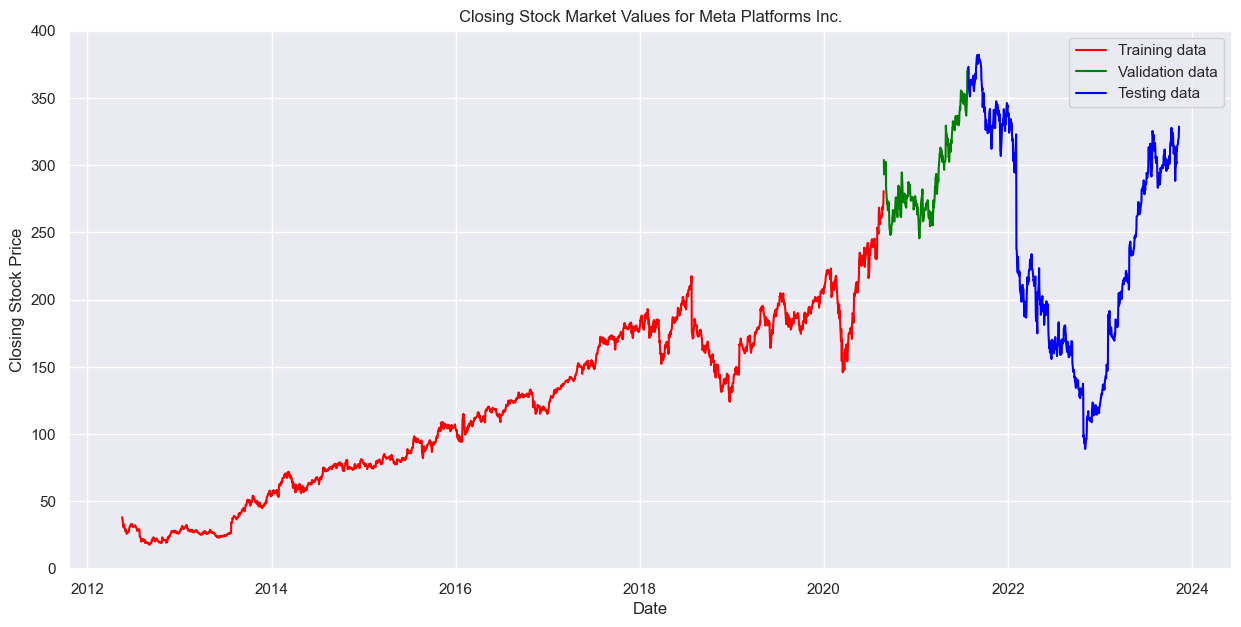

In [47]:
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# Set seaborn style for the plots
sns.set_theme()

# Define the split size for the data
split_size = 0.2
meta_data = meta.copy()  # Use the 'meta' dataset

# Calculate the size of the test set
size_test = int(np.round(len(meta_data) * split_size))
original_train_size = len(meta_data) - size_test

# Calculate the size of the validation set
size_val = int(np.round(original_train_size * (split_size / 2)))

# Calculate the size of the training set
size_train= original_train_size - size_val

# Create a plot with a specified figure size
plt.figure(figsize=(15,7))

# Plot the training data
plt.plot(meta_data.index.values[:size_train], meta_data['Close'].values[:size_train], label='Training data', color='red')

# Plot the validation data
plt.plot(meta_data.index.values[size_train:original_train_size], meta_data['Close'].values[size_train:original_train_size], label='Validation data', color='green')

# Plot the testing data
plt.plot(meta_data.index.values[original_train_size:], meta_data['Close'].values[original_train_size:], label='Testing data', color='blue')

# Customize the plot with labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.title('Closing Stock Market Values for Meta Platforms Inc.')
plt.legend()

# Show the plot
plt.show()


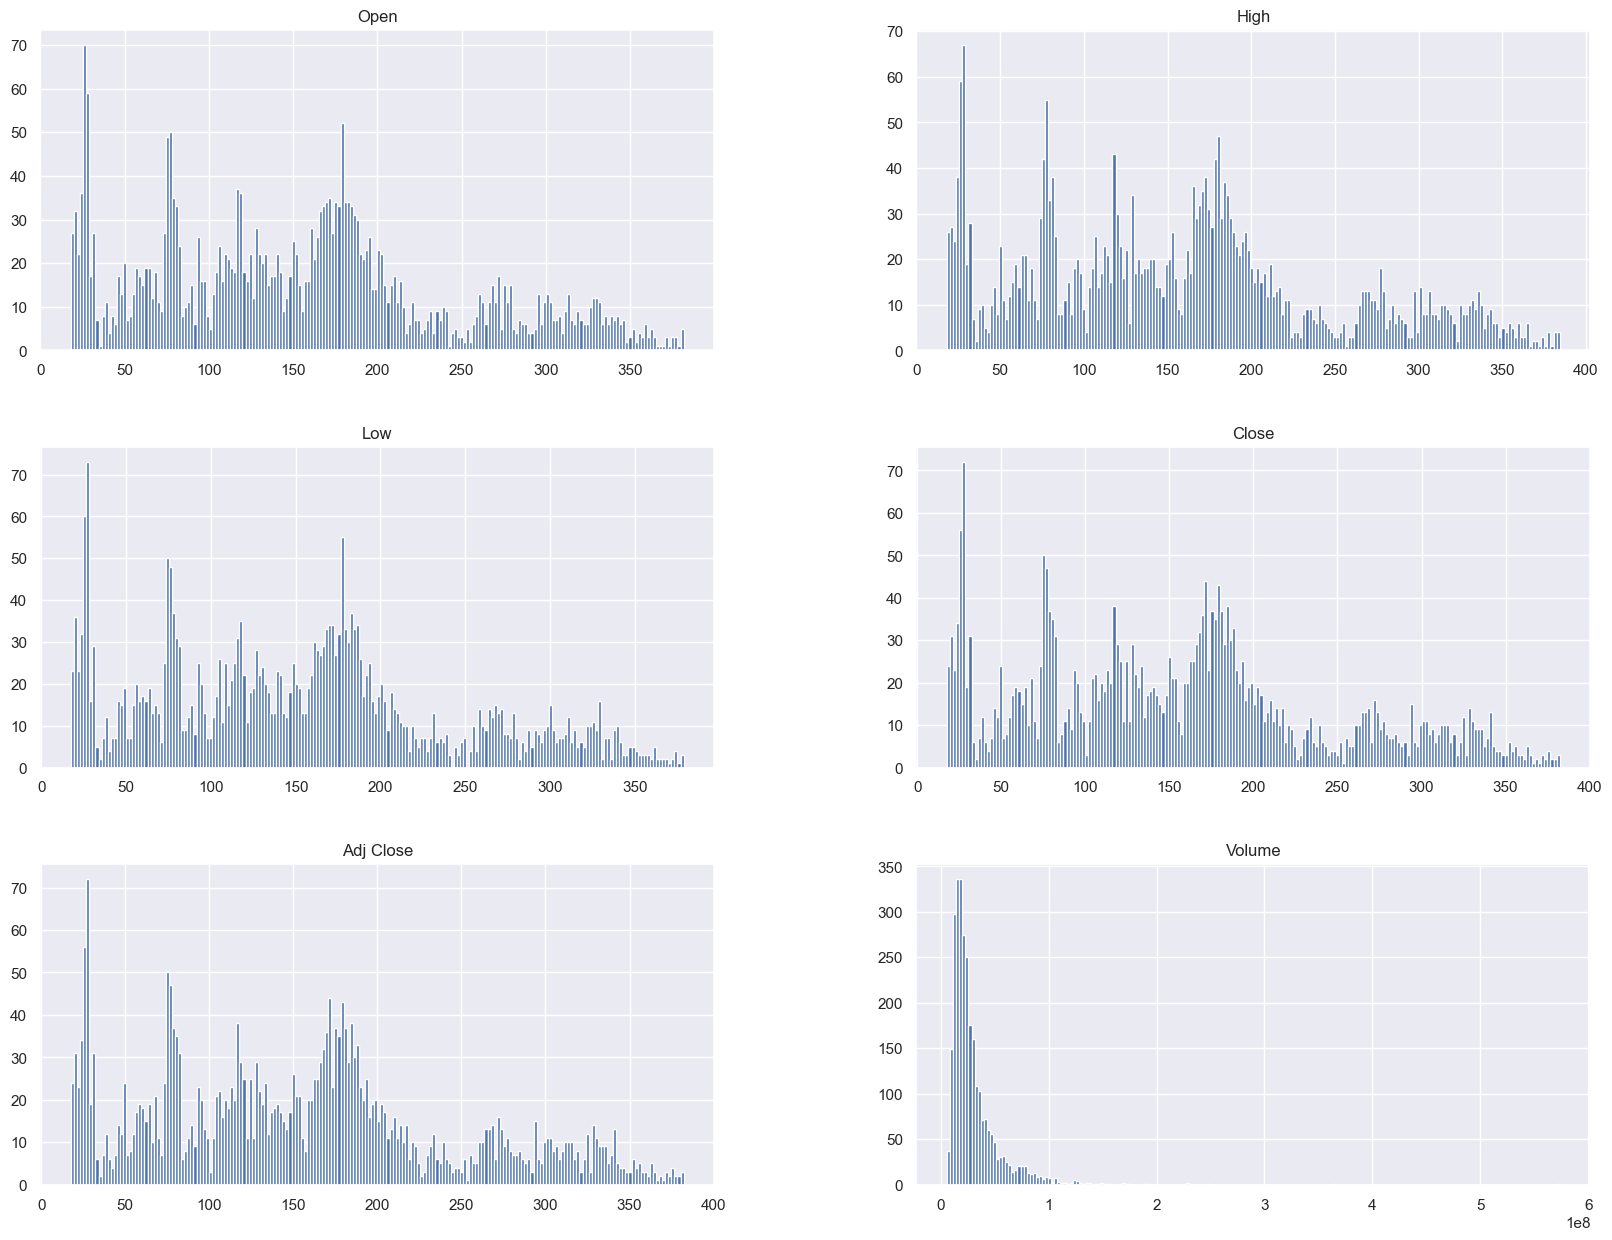

In [48]:
## plotting bar charts of all features
meta_plot = meta.copy()
meta_plot.hist(bins=200, figsize=(20,15))
plt.show()

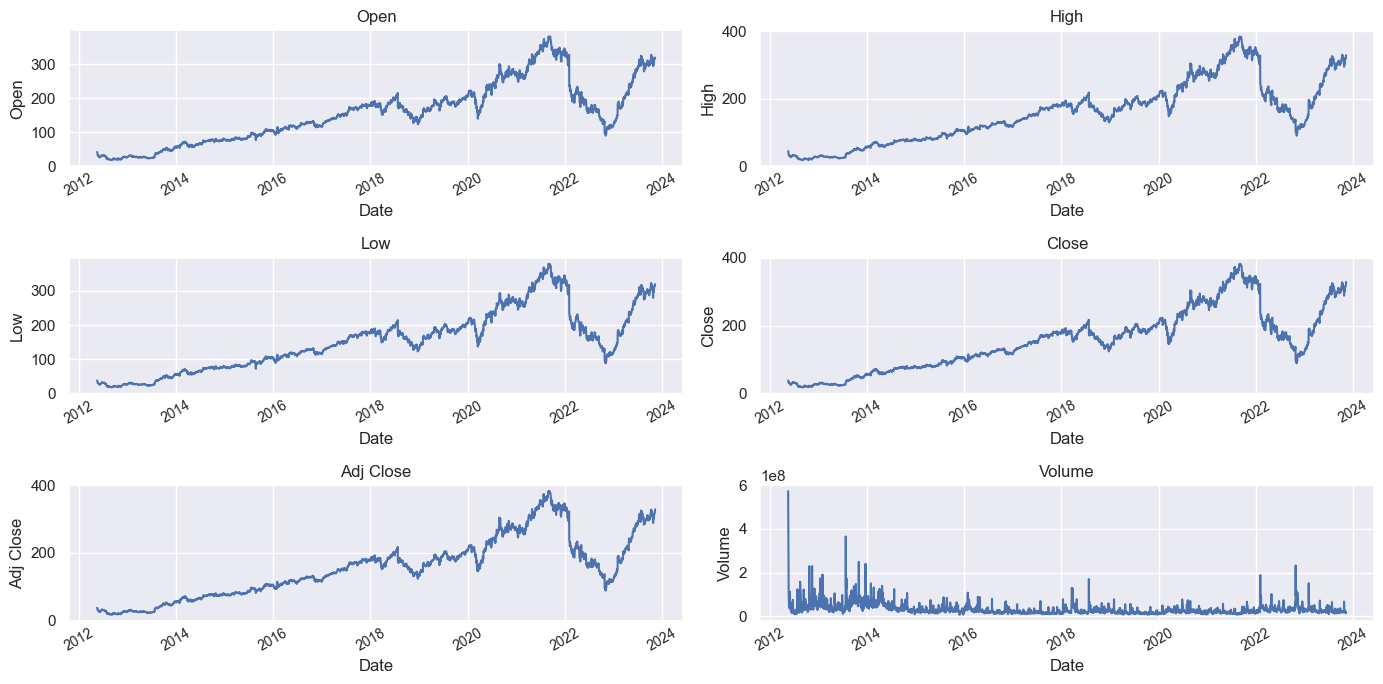

In [49]:
#plotting line charts
meta_plot = meta.copy()

# Determine the number of rows and columns for the subplots
ncols = 2
nrows = int(np.ceil(meta_plot.shape[1] / ncols))  # Use np.ceil to ensure enough rows

# Create a subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 7))

# Flatten the axes array for easy iteration if it's 2D (for multiple rows)
axes = axes.flatten()

# Iterate over the columns and the axes simultaneously
for i, column in enumerate(meta_plot.columns):
    sns.lineplot(data=meta_plot[column], ax=axes[i])
    axes[i].tick_params(axis="x", rotation=30, labelsize=10, length=0)
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[i].set_title(column)  # Optionally set title for each subplot

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plot
plt.show()


## Pre-processing some data

Next, we try to pre-process some data. There are numerous ways to pre-process data. It can involve removing non- necessary variables, scaling the rest of the variables to draw conclusions as accurate as possible. For example, here the Date variable provides no information except acting as something that keeps track of time. As in, it does not influence the stock predictions in any way. Thus, it makes sense to drop the Date variable , since it won't impact the stock patterns(if any) in any way. 

Similarly, the Adj Close column represents the close price of the stocks after adjustments for things like dividends and stock splits, and it is calculated after market flow. So, we may decide to drop it too.

In [50]:
# Sort the DataFrame by 'Date'
sorted_df = meta.sort_values(by=['Date']).copy()

# Remove the 'Adj Close' column, this represents the closing price of the stock, adjusted for things like dividends and stock splits
sorted_df.drop(['Adj Close'], axis=1, inplace=True)

# Create a new column 'Prediction' that duplicates the 'Close' column, since 'Close' is the target in our model, which we will try to predict, so renaming it makes sense
sorted_df['Prediction'] = sorted_df['Close'].copy()

# Display the last few rows of the DataFrame
print(sorted_df.tail())


                  Open        High         Low       Close    Volume  \
Date                                                                   
2023-11-06  315.980011  318.329987  314.450012  315.799988  12887700   
2023-11-07  317.059998  321.000000  315.119995  318.820007  14055600   
2023-11-08  318.140015  321.329987  314.880005  319.779999  13609700   
2023-11-09  319.420013  324.179993  318.799988  320.549988  16103100   
2023-11-10  319.940002  329.100006  319.459991  328.769989  19096200   

            Prediction  
Date                    
2023-11-06  315.799988  
2023-11-07  318.820007  
2023-11-08  319.779999  
2023-11-09  320.549988  
2023-11-10  328.769989  


### Creating a baseline


In [51]:
# initiating an empty list to create a baseline for the RNN model
rnn_baseline = []


# setting the data and true value (most recent closing price)
data = meta
true_value = data['Close'].iloc[-1]

# Function to calculate SMA, using simple moving average calculation on the closing price of the stock
def get_sma(rolling_window):
    return data['Close'].rolling(window=rolling_window).mean().iloc[-1]     # uses pandas' rolling().mean() to calculate the average cllosing price over the lat rolling window days 

# initializing list to store SMA results
sma_results = []

# calculating SMA for different rolling windows
for rolling_window in range(1, 100):  # Starting from 1 to avoid division by zero
    predicted = get_sma(rolling_window)    # getting the predicted values
    error = abs(predicted - true_value)    # getting the absolute error in prediction
    sma_results.append({
        'rolling_window': rolling_window,
        'true_value': true_value,
        'predicted_value': predicted,
        'error': error
    })

# Converting results to DataFrame and sorting by error
sma_results_df = pd.DataFrame(sma_results).sort_values(by=['error'])

'''
HEre, we afre looking to evaluate the summary statistics for the entire set of predictions,
doing it for each individual rolling window would not be practically meaningful in this case. 
They will be used further to compare the overall performance of different strategies emplyed in this
assignment. This is the reason why the below displayed MSE and MAPE are same for all the rows.
'''
# Calculating MSE and MAPE for the entire set of prdictions
mse = mean_squared_error(sma_results_df['true_value'][1:], sma_results_df['predicted_value'][1:])
mape = np.mean(np.abs((sma_results_df['true_value'][1:] - sma_results_df['predicted_value'][1:]) / sma_results_df['true_value'][1:])) * 100

overall_mse = mse
overall_mape = mape

# Displaying results, for all the rolling window values
sma_results_df['MSE'] = mse
sma_results_df['MAPE'] = mape
sma_results_df.head()

,rolling_window,true_value,predicted_value,error,MSE,MAPE
0,1,328.769989,328.769989,0.000000,412.351907,6.018941
1,2,328.769989,324.659988,4.110001,412.351907,6.018941
2,3,328.769989,323.033325,5.736664,412.351907,6.018941
3,4,328.769989,321.979996,6.789993,412.351907,6.018941
4,5,328.769989,320.743994,8.025995,412.351907,6.018941


In [52]:
# appending the last result to the baseline
rnn_baseline.append((100, overall_mse, overall_mape))
rnn_baseline_df = pd.DataFrame(rnn_baseline, columns=["Sequence length of window", "MSE", "MAPE"])
rnn_baseline_df

,Sequence length of window,MSE,MAPE
0,100,412.351907,6.018941


In [54]:
# Setting the date range and symbol for the data
start_date = date_start
end_date = date.today().strftime("%Y-%m-%d")

# Selecting the data for calculations
data = meta

# Setting the rolling window size for SMA calculation
rolling_window = 10

# Calculating the SMA and aligning it with the actual data
predicted_sma_values = data['Close'].rolling(window=rolling_window).mean()[rolling_window - 1:]
true_values = data['Close'][rolling_window - 1:]

# Calculate the Mean Squared Error between the true values and predicted SMA
mse = mean_squared_error(true_values, predicted_sma_values)
print("Mean Squared Error:", mse)


Mean Squared Error: 44.97310591599952


### Creating a base class containing important methods(parts of this code are taken from the class code) 

In [90]:
class BaseNN:

    def __init__(self, index_Close, sequence_length):
        self.index_Close = index_Close    # refers to the column index of the close price on the dataset
        self.sequence_length = sequence_length
        self.train_set, self.val_set, self.test_set = None, None, None
        self.optimizer, self.epoch, self.stopped_epoch = None, None, None

    def preprocess_data(self, sorted_df):
        scaler = MinMaxScaler()  # using scalar for normalization
        data_scaled = scaler.fit_transform(sorted_df)    # using  date wise sorted dataframe for fitting

        df_Close = pd.DataFrame(sorted_df['Close'])
        scaler_pred = MinMaxScaler()
        df_Close_scaled = scaler_pred.fit_transform(df_Close)

        return data_scaled, scaler_pred, df_Close_scaled

    def partition_dataset(self, data):
        x, y = [], []     # splitting the data into sequences of x and y based on the sequence length
        for i in range(self.sequence_length, len(data)):
            x.append(data[i - self.sequence_length:i, :])
            y.append(data[i, self.index_Close])
        return np.array(x), np.array(y)

    def split_data(self, data, split_size):
        # splitting the data into training, test and validation sets
        data = np.array(data)
        test_size = int(np.round(len(data) * split_size))
        original_train_size = len(data) - test_size 
        val_size = int(np.round(original_train_size*(split_size/2)))
        train_size = original_train_size - val_size
        # train_size = len(data) - test_size - int(np.round(test_size * split_size / 2))

        self.train_set = data[:train_size, :]
        self.val_set = data[train_size:original_train_size ,:]
        self.test_set = data[original_train_size:, :]

        print("Training Size :",len(self.train_set))
        print("Validation Size :",len(self.val_set))
        print("Testing Size :",len(self.test_set))

        x_train, y_train = self.partition_dataset(self.train_set)
        x_val, y_val = self.partition_dataset(self.val_set)
        x_test, y_test = self.partition_dataset(self.test_set)

        print(f"X_Training Shape : {x_train.shape}")
        print(f"y_Training Shape : {y_train.shape}")
        print(f"X_Validation : {x_val.shape}")
        print(f"Y_Validation : {y_val.shape}")
        print(f"X_Testing : {x_test.shape}")
        print(f"Y_Testing : {y_test.shape}")

        return x_train, y_train, x_val, y_val, x_test, y_test

    def train(self, model, epochs, x_train, y_train, x_val, y_val, scaler_pred, batch_size):
        
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                            validation_data=(x_val, y_val), callbacks=[early_stop])

        y_pred_scaled = model.predict(x_val)
        y_pred = scaler_pred.inverse_transform(y_pred_scaled)
        y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

        self.stopped_epoch = early_stop.stopped_epoch
        return history,y_pred_scaled, y_pred, y_val_unscaled

    def plot_loss(self, history):
        plt.figure(figsize=(16, 5))
        plt.plot(history.history['loss'], label="Training Loss")
        plt.plot(history.history['val_loss'], label="Validation Loss")
        plt.title("Model Loss Over Epochs")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(loc="upper right")
        plt.grid()
        plt.show()


## Vanilla RNN
Create and compiling two different types of Recurrent Neural Network (RNN) models for time series prediction

In [91]:
class Vanilla_RNN(BaseNN):
    # defining the intial parameters, taking into account that the Vanilla RNN is the inherited class from the base class
    def __init__(self, index_Close, sequence_length):
        super().__init__(index_Close, sequence_length)
        self.x_train = None
        self.y_pred = None

    def Vanilla_RNN_model(self, x_train, optimizer='adam', lr=0.001):
        """Create a vanilla RNN model with tanh activation."""

        # Set the optimizer
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

        # Determine the number of neurons in each RNN layer
        n_neurons = x_train.shape[1] * x_train.shape[2]

        # Initialize the Sequential model
        regressor = Sequential()

        # Add RNN layers with dropout for regularization
        regressor.add(SimpleRNN(units=n_neurons, activation="tanh", return_sequences=True,
                                input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(0.2))
        regressor.add(SimpleRNN(units=n_neurons, activation="tanh", return_sequences=True))
        regressor.add(SimpleRNN(units=n_neurons))

        # Add dense layers
        regressor.add(Dense(5))
        regressor.add(Dense(units=1))

        # Compile the model
        regressor.compile(optimizer=self.optimizer, loss="mean_squared_error")

        return regressor

    def Vanilla_RNN_relu_model(self, x_train, optimizer='adam', lr=0.001):
        """Create a vanilla RNN model with ReLU activation."""

        # Set the optimizer
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

        # Determine the number of neurons in each RNN layer
        n_neurons = x_train.shape[1] * x_train.shape[2]

        # Initialize the Sequential model
        regressor = Sequential()

        # Add RNN layers with dropout for regularization
        regressor.add(SimpleRNN(units=n_neurons, activation=tf.nn.relu, return_sequences=True,
                                input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(0.2))
        regressor.add(SimpleRNN(units=n_neurons, activation=tf.nn.relu, return_sequences=True))
        regressor.add(SimpleRNN(units=n_neurons, activation=tf.nn.relu))

        # Add dense layers
        regressor.add(Dense(5))
        regressor.add(Dense(units=1))

        # Compile the model
        regressor.compile(optimizer=self.optimizer, loss="mean_squared_error")

        return regressor


#### Creating an instance of the vanilla RNN and checking its performance on the validation set

Training Size : 2081
Validation Size : 231
Testing Size : 578
X_Training Shape : (2061, 20, 6)
y_Training Shape : (2061,)
X_Validation : (211, 20, 6)
Y_Validation : (211,)
X_Testing : (558, 20, 6)
Y_Testing : (558,)
Epoch 1/100


2023-11-13 21:10:40.572428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 6.0055

2023-11-13 21:11:41.401891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 62s 476ms/step - loss: 6.0055 - val_loss: 0.3698
Epoch 2/100
129/129 [==============================] - 57s 441ms/step - loss: 0.0393 - val_loss: 0.1781
Epoch 3/100
129/129 [==============================] - 57s 438ms/step - loss: 0.0461 - val_loss: 0.3978
Epoch 4/100
129/129 [==============================] - 59s 456ms/step - loss: 0.0460 - val_loss: 0.1653
Epoch 5/100
129/129 [==============================] - 58s 452ms/step - loss: 0.0356 - val_loss: 0.3449
Epoch 6/100
129/129 [==============================] - 57s 439ms/step - loss: 0.0484 - val_loss: 0.2853
Epoch 7/100
129/129 [==============================] - 57s 443ms/step - loss: 0.0341 - val_loss: 0.2156
Epoch 8/100
129/129 [==============================] - 56s 435ms/step - loss: 0.0362 - val_loss: 0.2566
Epoch 9/100
129/129 [==============================] - 56s 437ms/step - loss: 0.0300 - val_loss: 0.4208
Epoch 9: early stopping
2/7 [=======>......................] - ETA: 0s

2023-11-13 21:19:19.265570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 58ms/step


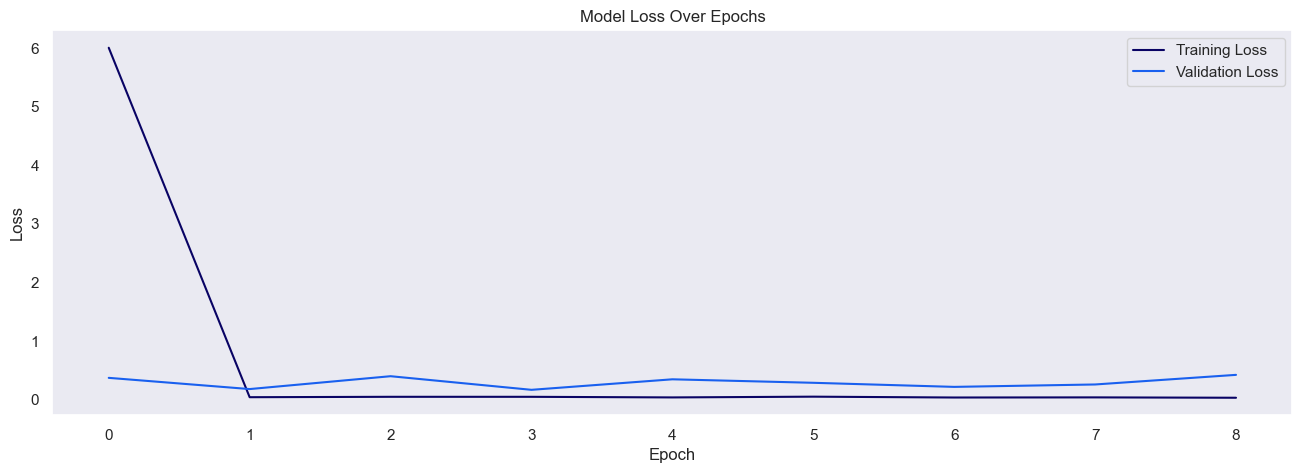

Mean Absolute Error (MAE): 234.39
Mean Absolute Percentage Error (MAPE): 79.82 %
Median Absolute Percentage Error (MDAPE): 79.02 %


In [92]:
# Setting up model parameters
optimizer = 'adam'
lr = 0.1
batch_size = 16
epochs = 100
index_Close = 3  # Index of the 'Close' column in the dataset
sequence_length = 20  # Number of time steps to look back for prediction

# Initializing the RNN model
vrnn = Vanilla_RNN(index_Close, sequence_length)

# Preprocessing the data
data_scaled, scaler_pred, df_Close_scaled = vrnn.preprocess_data(sorted_df)

# Splitting the data into training, validation, and test sets
x_train, y_train, x_val, y_val, x_test, y_test = vrnn.split_data(data_scaled, split_size=0.2)

# Initializing and create the VRNN model
model1_vrnn = vrnn.Vanilla_RNN_model(x_train, optimizer=optimizer, lr=lr)

# Training the model
history, y_pred_scaled, y_pred, y_val_unscaled = vrnn.train(
    model1_vrnn, epochs=epochs, x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val, scaler_pred=scaler_pred, batch_size=batch_size)

# Plotting training and validation loss values
vrnn.plot_loss(history)

# Calculating and printing the Mean Absolute Error (MAE)
mean_abs_error = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(mean_abs_error, 2)}')

# Calculating and printing the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape, 2)} %')

# Calculating and printing the Median Absolute Percentage Error (MDAPE)
mdape = np.median(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(mdape, 2)} %')


In [93]:
model1_vrnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_27 (SimpleRNN)   (None, 20, 120)           15240     
                                                                 
 dropout_9 (Dropout)         (None, 20, 120)           0         
                                                                 
 simple_rnn_28 (SimpleRNN)   (None, 20, 120)           28920     
                                                                 
 simple_rnn_29 (SimpleRNN)   (None, 120)               28920     
                                                                 
 dense_18 (Dense)            (None, 5)                 605       
                                                                 
 dense_19 (Dense)            (None, 1)                 6         
                                                                 
Total params: 73691 (287.86 KB)
Trainable params: 7369

### Visualisation of the model

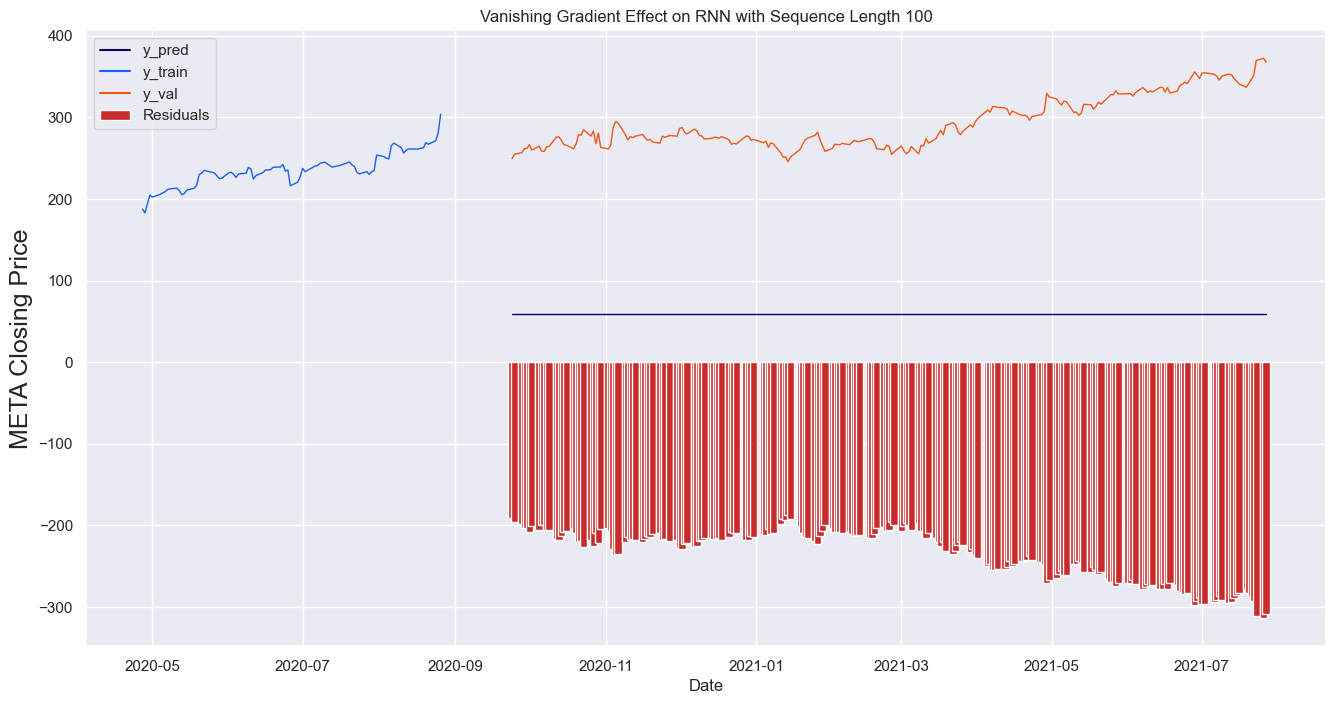

In [94]:
# Settinh the start date for display in the plot
display_start_date = date_start

# Calculating the lengths of the training and validation datasets
train_data_len = len(vrnn.train_set)
val_data_len = len(vrnn.train_set) + len(vrnn.val_set)

# Defining the start point for plotting the training data
start = int(train_data_len * 0.95 + vrnn.sequence_length)

# Preparing the training and validation data for plotting
df_Close = pd.DataFrame(sorted_df['Close'])
train = pd.DataFrame(df_Close['Close'][start:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len + vrnn.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})

# Adding predicted values and residuals (difference between predicted and actual values) to the validation data
valid['y_pred'] = y_pred
valid['residuals'] = valid['y_pred'] - valid['y_val']

# Combining training and validation data for plotting
df_union = pd.concat([train, valid])

# Zooming into a specific timeframe for a detailed view
df_union_zoom = df_union[df_union.index > display_start_date]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Vanishing Gradient Effect on RNN with Sequence Length 100")
plt.ylabel("META Closing Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Adding a bar plot for the residuals
color_map = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='Residuals', color=color_map)
plt.legend()
plt.show()


#### Creating another instance with different parameters

Training Size : 2081
Validation Size : 231
Testing Size : 578
X_Training Shape : (2061, 20, 6)
y_Training Shape : (2061,)
X_Validation : (211, 20, 6)
Y_Validation : (211,)
X_Testing : (558, 20, 6)
Y_Testing : (558,)
Epoch 1/100


2023-11-13 21:19:20.704869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 0.0011

2023-11-13 21:20:19.536472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 60s 460ms/step - loss: 0.0011 - val_loss: 0.0068
Epoch 2/100
129/129 [==============================] - 59s 456ms/step - loss: 1.6685e-04 - val_loss: 0.0028
Epoch 3/100
129/129 [==============================] - 58s 451ms/step - loss: 1.3784e-04 - val_loss: 0.0022
Epoch 4/100
129/129 [==============================] - 60s 465ms/step - loss: 1.2108e-04 - val_loss: 0.0037
Epoch 5/100
129/129 [==============================] - 59s 460ms/step - loss: 1.5698e-04 - val_loss: 0.0018
Epoch 6/100
129/129 [==============================] - 63s 487ms/step - loss: 1.2175e-04 - val_loss: 0.0060
Epoch 7/100
129/129 [==============================] - 58s 453ms/step - loss: 1.4618e-04 - val_loss: 0.0037
Epoch 8/100
129/129 [==============================] - 60s 465ms/step - loss: 1.0914e-04 - val_loss: 0.0046
Epoch 9/100
129/129 [==============================] - 61s 470ms/step - loss: 1.2153e-04 - val_loss: 0.0031
Epoch 10/100
129/129 [======================

2023-11-13 21:29:20.227400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 58ms/step


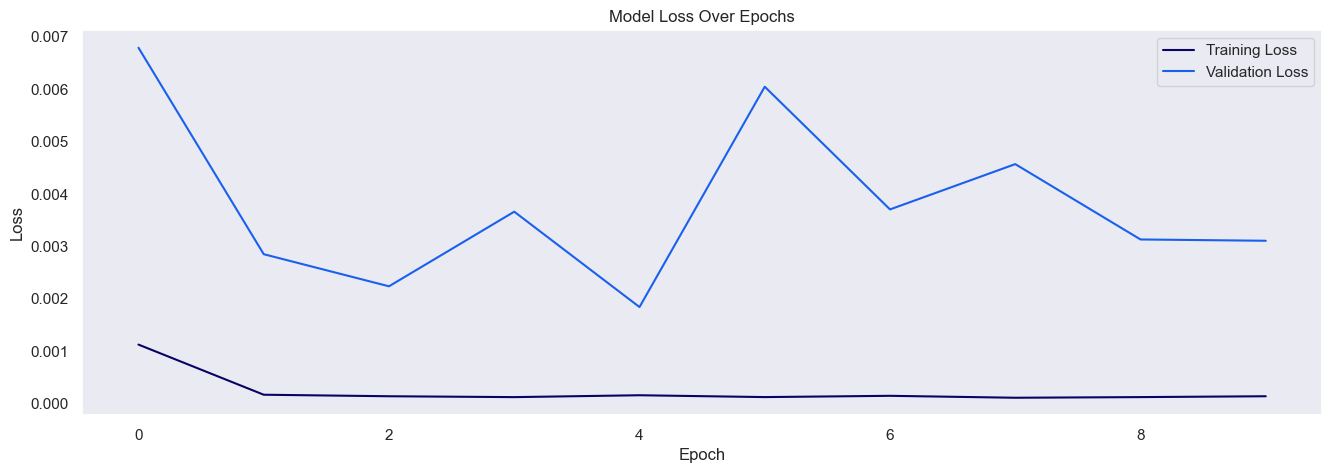

Mean Absolute Error (MAE): 19.32
Mean Absolute Percentage Error (MAPE): 6.55 %
Median Absolute Percentage Error (MDAPE): 6.43 %


In [95]:
# Setting up model parameters
optimizer = 'adam'
lr = 0.001
batch_size = 16
epochs = 100
index_Close = 3  # Index of the 'Close' column in the dataset
sequence_length = 20  # Number of time steps to look back for prediction

# Initializing the RNN model
vrnn = Vanilla_RNN(index_Close, sequence_length)

# Preprocessing the data
data_scaled, scaler_pred, df_Close_scaled = vrnn.preprocess_data(sorted_df)

# Splitting the data into training, validation, and test sets
x_train, y_train, x_val, y_val, x_test, y_test = vrnn.split_data(data_scaled, split_size=0.2)

# Initializing and create the VRNN model
model2_vrnn = vrnn.Vanilla_RNN_relu_model(x_train, optimizer=optimizer, lr=lr)

# Training the model
history, y_pred_scaled, y_pred, y_val_unscaled = vrnn.train(
    model2_vrnn, epochs=epochs, x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val, scaler_pred=scaler_pred, batch_size=batch_size
)

# Plotting training and validation loss values
vrnn.plot_loss(history)

# Calculating and printing the Mean Absolute Error (MAE)
mean_abs_error = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(mean_abs_error, 2)}')

# Calculating and printing the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape, 2)} %')

# Calculating and printing the Median Absolute Percentage Error (MDAPE)
mdape = np.median(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(mdape, 2)} %')


In [96]:
model2_vrnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 20, 120)           15240     
                                                                 
 dropout_10 (Dropout)        (None, 20, 120)           0         
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 20, 120)           28920     
                                                                 
 simple_rnn_32 (SimpleRNN)   (None, 120)               28920     
                                                                 
 dense_20 (Dense)            (None, 5)                 605       
                                                                 
 dense_21 (Dense)            (None, 1)                 6         
                                                                 
Total params: 73691 (287.86 KB)
Trainable params: 736

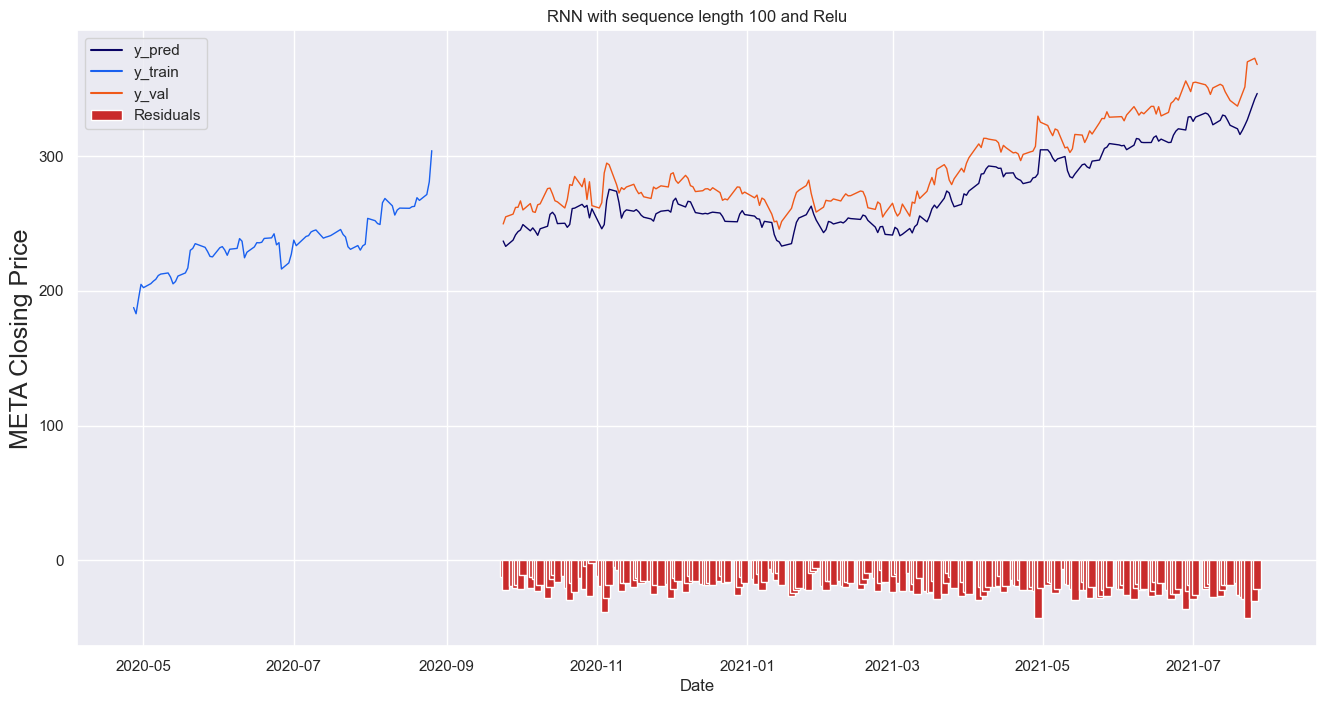

In [97]:
# Settinh the start date for display in the plot
display_start_date = date_start

# Calculating the lengths of the training and validation datasets
train_data_len = len(vrnn.train_set)
val_data_len = len(vrnn.train_set) + len(vrnn.val_set)

# Defining the start point for plotting the training data
start = int(train_data_len * 0.95 + vrnn.sequence_length)

# Preparing the training and validation data for plotting
df_Close = pd.DataFrame(sorted_df['Close'])
train = pd.DataFrame(df_Close['Close'][start:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len + vrnn.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})

# Adding predicted values and residuals (difference between predicted and actual values) to the validation data
valid['y_pred'] = y_pred
valid['residuals'] = valid['y_pred'] - valid['y_val']

# Combining training and validation data for plotting
df_union = pd.concat([train, valid])

# Zooming into a specific timeframe for a detailed view
df_union_zoom = df_union[df_union.index > display_start_date]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("RNN with sequence length 100 and Relu")
plt.ylabel("META Closing Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Adding a bar plot for the residuals
color_map = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='Residuals', color=color_map)
plt.legend()
plt.show()


### Using the better model from above to make the final prediction for next day

In [99]:
# Preparing test data for prediction
df_fin = vrnn.test_set[-vrnn.sequence_length:]

# Extracting the last known price (today's price)
price_today = np.round(df_fin[-1][3], 2)
price_today = scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"Price Today: {price_today}")

# Preparing the test data for the model
X_test_new = [df_fin]

# Making prediction using the trained model
pred_price_scaled = model2_vrnn.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
print(f"Predicted Price for the Next Day: {predicted_price}")

# Calculating and printing the percentage change
change_percent = np.round(100 - (price_today * 100) / predicted_price, 2)
sign = '+' if change_percent > 0 else ''
print(f'The predicted close price is {predicted_price} ({sign}{change_percent}%)')


Price Today: [[327.51249371]]
1/1 [==============================] - 0s 101ms/step
Predicted Price for the Next Day: 304.8399963378906
The predicted close price is 304.8399963378906 ([[-7.44]]%)


# Long Short-Term Memory

In [112]:
class LSTM_NN(BaseNN):
    def __init__(self,index_Close,sequence_length):
        super().__init__(index_Close,sequence_length)
        self.x_train = None
        self.y_pred =None


    def LSTM_model(self, x_train, optimizer='adam', lr=0.001):
        """Create an LSTM model."""

        # Setting the optimizer
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

        # Defining the LSTM model
        model = Sequential()

        # Number of neurons 
        n_neurons = x_train.shape[1] * x_train.shape[2]

        # adding first LSTM layer with Dropout regularization
        model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.2))

        # adding second LSTM layer
        model.add(LSTM(n_neurons, return_sequences=True))

        # adding third LSTM layer
        model.add(LSTM(n_neurons))

        # adding the dense layers
        model.add(Dense(5))
        model.add(Dense(1))

        # Compiling the model
        model.compile(optimizer=self.optimizer, loss='mse')

        return model


### Creating an instance of LSTM

Training Size : 2081
Validation Size : 231
Testing Size : 578
X_Training Shape : (2061, 20, 6)
y_Training Shape : (2061,)
X_Validation : (211, 20, 6)
Y_Validation : (211,)
X_Testing : (558, 20, 6)
Y_Testing : (558,)


Epoch 1/100


2023-11-14 10:16:48.886706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:49.159820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:49.241734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:49.305031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:49.409522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:49.513762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  2/129 [..............................] - ETA: 8s - loss: 0.0750  

2023-11-14 10:16:49.650731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 0.0055

2023-11-14 10:16:52.589526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:52.680635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:52.735698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:16:52.785375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 5s 25ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 2/100
129/129 [==============================] - 2s 18ms/step - loss: 4.1082e-04 - val_loss: 0.0014
Epoch 3/100
129/129 [==============================] - 2s 17ms/step - loss: 4.0831e-04 - val_loss: 0.0011
Epoch 4/100
129/129 [==============================] - 2s 16ms/step - loss: 4.0586e-04 - val_loss: 0.0010
Epoch 5/100
129/129 [==============================] - 2s 15ms/step - loss: 3.9444e-04 - val_loss: 0.0015
Epoch 6/100
129/129 [==============================] - 2s 16ms/step - loss: 3.5831e-04 - val_loss: 0.0013
Epoch 7/100
129/129 [==============================] - 2s 17ms/step - loss: 3.7140e-04 - val_loss: 0.0017
Epoch 8/100
129/129 [==============================] - 2s 16ms/step - loss: 3.4988e-04 - val_loss: 0.0016
Epoch 9/100
129/129 [==============================] - 2s 17ms/step - loss: 3.5496e-04 - val_loss: 0.0016
Epoch 9: early stopping


2023-11-14 10:17:10.326562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:17:10.414552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:17:10.465715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:17:10.520768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 14ms/step


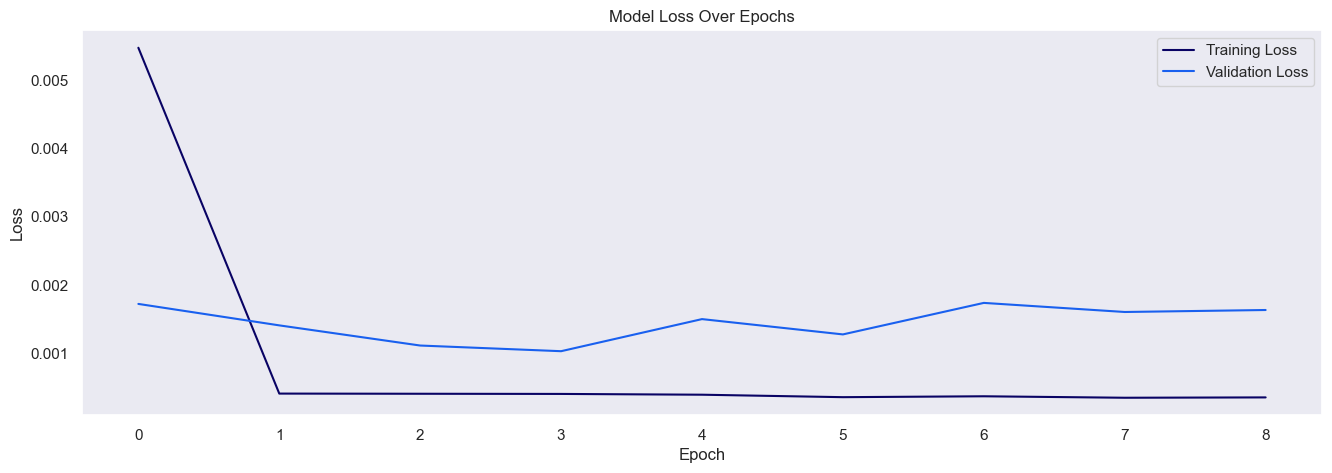

Mean Absolute Error (MAE): 12.29
Mean Absolute Percentage Error (MAPE): 4.39 %
Median Absolute Percentage Error (MDAPE): 3.9 %


In [113]:
# Setting up model parameters
optimizer = 'adam'
lr = 0.0001
batch_size = 16
epochs = 100
index_Close = 3  # Index of the 'Close' column in the dataset
sequence_length = 20  # Number of time steps to look back for prediction

# Initializing the model
lstm1 = LSTM_NN(index_Close, sequence_length)

# Preprocessing the data
data_scaled, scaler_pred, df_Close_scaled = lstm1.preprocess_data(sorted_df)

# Splitting the data into training, validation, and test sets
x_train, y_train, x_val, y_val, x_test, y_test = lstm1.split_data(data_scaled, split_size=0.2)

# Initializing and create the VRNN model
model1_lstm = lstm1.LSTM_model(x_train, optimizer=optimizer, lr=lr)

# Training the model
history, y_pred_scaled, y_pred, y_val_unscaled = lstm1.train(
    model1_lstm, epochs=epochs, x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val, scaler_pred=scaler_pred, batch_size=batch_size
)

# Plotting training and validation loss values
lstm1.plot_loss(history)

# Calculating and printing the Mean Absolute Error (MAE)
mean_abs_error = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(mean_abs_error, 2)}')

# Calculating and printing the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape, 2)} %')

# Calculating and printing the Median Absolute Percentage Error (MDAPE)
mdape = np.median(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(mdape, 2)} %')


In [114]:
model1_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20, 120)           60960     
                                                                 
 dropout_12 (Dropout)        (None, 20, 120)           0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 120)           115680    
                                                                 
 lstm_5 (LSTM)               (None, 120)               115680    
                                                                 
 dense_24 (Dense)            (None, 5)                 605       
                                                                 
 dense_25 (Dense)            (None, 1)                 6         
                                                                 
Total params: 292931 (1.12 MB)
Trainable params: 2929

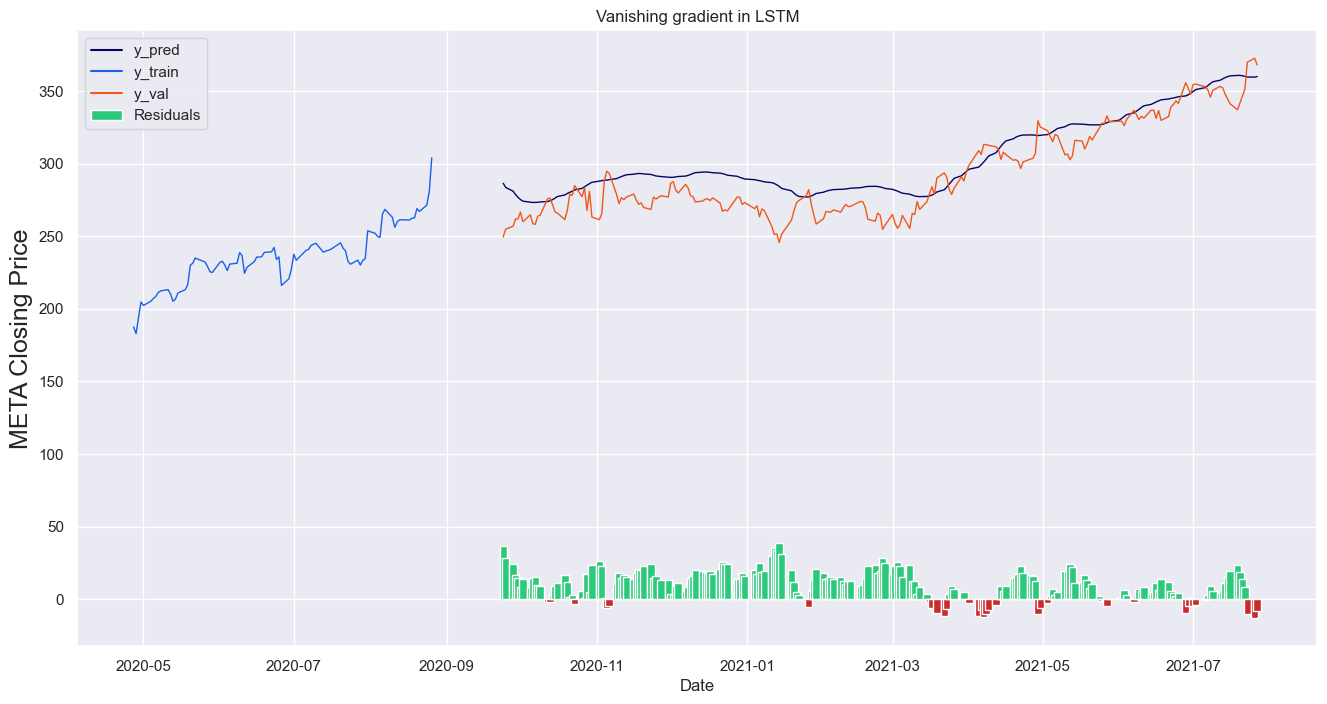

In [115]:
# Settinh the start date for display in the plot
display_start_date = date_start

# Calculating the lengths of the training and validation datasets
train_data_len = len(lstm1.train_set)
val_data_len = len(lstm1.train_set) + len(lstm1.val_set)

# Defining the start point for plotting the training data
start = int(train_data_len * 0.95 + lstm1.sequence_length)

# Preparing the training and validation data for plotting
df_Close = pd.DataFrame(sorted_df['Close'])
train = pd.DataFrame(df_Close['Close'][start:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len + lstm1.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})

# Adding predicted values and residuals (difference between predicted and actual values) to the validation data
valid['y_pred'] = y_pred
valid['residuals'] = valid['y_pred'] - valid['y_val']

# Combining training and validation data for plotting
df_union = pd.concat([train, valid])

# Zooming into a specific timeframe for a detailed view
df_union_zoom = df_union[df_union.index > display_start_date]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Vanishing gradient in LSTM")
plt.ylabel("META Closing Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Adding a bar plot for the residuals
color_map = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='Residuals', color=color_map)
plt.legend()
plt.show()


### Making the final prediction on the test set

In [116]:
# Preparing test data for prediction
df_fin_lstm = lstm1.test_set[-lstm1.sequence_length:]

# Extracting the last known price (today's price)
price_today = np.round(df_fin_lstm[-1][3], 2)
price_today = scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"Price Today: {price_today}")

# Preparing the test data for the model
X_test_new = [df_fin_lstm]

# Making prediction using the trained model
pred_price_scaled = model1_lstm.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
print(f"Predicted Price for the Next Day: {predicted_price}")

# Calculating and printing the percentage change
change_percent = np.round(100 - (price_today * 100) / predicted_price, 2)
sign = '+' if change_percent > 0 else ''
print(f'The predicted close price is {predicted_price} ({sign}{change_percent}%)')


Price Today: [[327.51249371]]
1/1 [==============================] - 0s 40ms/step
Predicted Price for the Next Day: 323.8699951171875
The predicted close price is 323.8699951171875 ([[-1.12]]%)


# Gated Recurrent Unit(GRU)

In [117]:
class GRU_NN(BaseNN):
    def __init__(self, index_Close, sequence_length):
        """Initializing the GRU model with index of close price and sequence length."""
        super().__init__(index_Close, sequence_length)
        self.x_train = None  # Placeholder for training data
        self.y_pred = None   # Placeholder for model predictions

    def GRU_model(self, x_train, optimizer='adam', lr=0.001):
        """Creating a GRU model."""
        
        # Set the optimizer based on the provided choice
        if optimizer == 'adam':
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer == 'sgd':
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)

        # Calculating the number of neurons for each GRU layer
        n_neurons = x_train.shape[1] * x_train.shape[2]

        # Initializing the Sequential model
        GRU1 = Sequential()

        # Adding first GRU layer with Dropout regularization
        GRU1.add(GRU(units=n_neurons, return_sequences=True, 
                             input_shape=(x_train.shape[1], x_train.shape[2]), 
                             activation='tanh'))
        GRU1.add(Dropout(0.2))

        # Adding second GRU layer
        GRU1.add(GRU(units=n_neurons, return_sequences=True, activation='tanh'))
        
        # Adding third GRU layer
        GRU1.add(GRU(units=n_neurons, activation='tanh'))

        # Adding dense layers
        GRU1.add(Dense(units=5))  # Intermediate dense layer with 5 neurons
        GRU1.add(Dense(units=1))  # Output layer with 1 neuron (for regression output)

        # Compiling the model with mean squared error loss
        GRU1.compile(optimizer=self.optimizer, loss='mse')

        # Debugging print statement showing how n_neurons is calculated
        print(f"{n_neurons} neurons: Calculated as {x_train.shape[1]} (time steps) * {x_train.shape[2]} (features per step)")

        return GRU1


### Creating and instance and checking its performance

Training Size : 2081
Validation Size : 231
Testing Size : 578
X_Training Shape : (2061, 20, 6)
y_Training Shape : (2061,)
X_Validation : (211, 20, 6)
Y_Validation : (211,)
X_Testing : (558, 20, 6)
Y_Testing : (558,)


120 neurons: Calculated as 20 (time steps) * 6 (features per step)
Epoch 1/100


2023-11-14 10:19:29.349788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:29.601496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:29.723296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:29.770629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:29.866664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:30.276084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:30.398362: I tensorflow/core/grappler/optimizers/cust

129/129 [==============================] - ETA: 0s - loss: 0.0022

2023-11-14 10:19:33.045326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:33.128300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:33.170007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:19:33.209987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 5s 23ms/step - loss: 0.0022 - val_loss: 5.5885e-04
Epoch 2/100
129/129 [==============================] - 2s 16ms/step - loss: 1.5693e-04 - val_loss: 4.9114e-04
Epoch 3/100
129/129 [==============================] - 2s 16ms/step - loss: 1.5819e-04 - val_loss: 6.1756e-04
Epoch 4/100
129/129 [==============================] - 2s 16ms/step - loss: 1.4380e-04 - val_loss: 0.0016
Epoch 5/100
129/129 [==============================] - 2s 16ms/step - loss: 1.6508e-04 - val_loss: 5.0192e-04
Epoch 6/100
129/129 [==============================] - 2s 15ms/step - loss: 1.4485e-04 - val_loss: 3.6314e-04
Epoch 7/100
129/129 [==============================] - 2s 16ms/step - loss: 1.1786e-04 - val_loss: 4.3585e-04
Epoch 8/100
129/129 [==============================] - 2s 18ms/step - loss: 1.2118e-04 - val_loss: 0.0011
Epoch 9/100
129/129 [==============================] - 2s 16ms/step - loss: 1.6113e-04 - val_loss: 3.5355e-04
Epoch 10/100
129/129 [============

2023-11-14 10:20:15.350040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:20:15.426768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:20:15.466845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:20:15.525584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 19ms/step


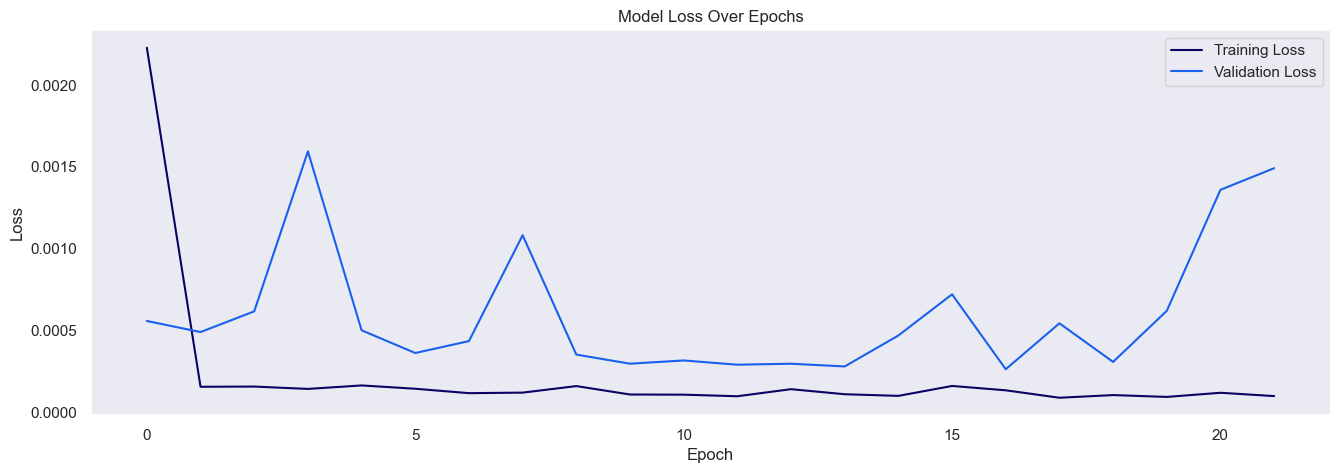

Mean Absolute Error (MAE): 12.77
Mean Absolute Percentage Error (MAPE): 4.3 %
Median Absolute Percentage Error (MDAPE): 4.16 %


In [118]:
# Setting up model parameters
optimizer = 'adam'
lr = 0.001
batch_size = 16
epochs = 100
index_Close = 3  # Index of the 'Close' column in the dataset
sequence_length = 20  # Number of time steps to look back for prediction

# Initializing the GRU model
gru1 = GRU_NN(index_Close, sequence_length)

# Preprocessing the data
data_scaled, scaler_pred, df_Close_scaled = gru1.preprocess_data(sorted_df)

# Splitting the data into training, validation, and test sets
x_train, y_train, x_val, y_val, x_test, y_test = gru1.split_data(data_scaled, split_size=0.2)

# Initializing and create the VRNN model
model1_gru = gru1.GRU_model(x_train, optimizer=optimizer, lr=lr)

# Training the model
history, y_pred_scaled, y_pred, y_val_unscaled = gru1.train(
    model1_gru, epochs=epochs, x_train=x_train, y_train=y_train,
    x_val=x_val, y_val=y_val, scaler_pred=scaler_pred, batch_size=batch_size
)

# Plotting training and validation loss values
gru1.plot_loss(history)

# Calculating and printing the Mean Absolute Error (MAE)
mean_abs_error = mean_absolute_error(y_val_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(mean_abs_error, 2)}')

# Calculating and printing the Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape, 2)} %')

# Calculating and printing the Median Absolute Percentage Error (MDAPE)
mdape = np.median(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(mdape, 2)} %')


In [119]:
model1_gru.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 120)           46080     
                                                                 
 dropout_13 (Dropout)        (None, 20, 120)           0         
                                                                 
 gru_1 (GRU)                 (None, 20, 120)           87120     
                                                                 
 gru_2 (GRU)                 (None, 120)               87120     
                                                                 
 dense_26 (Dense)            (None, 5)                 605       
                                                                 
 dense_27 (Dense)            (None, 1)                 6         
                                                                 
Total params: 220931 (863.01 KB)
Trainable params: 22

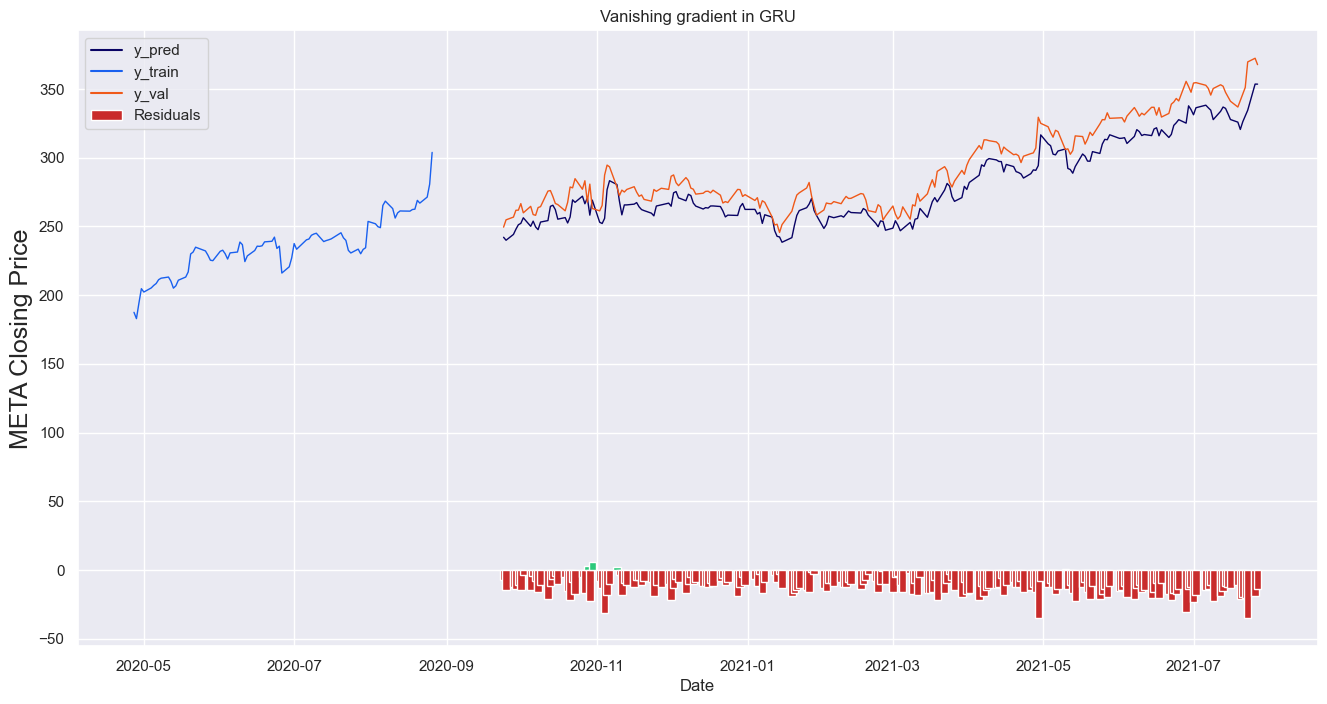

In [120]:
# Settinh the start date for display in the plot
display_start_date = date_start

# Calculating the lengths of the training and validation datasets
train_data_len = len(gru1.train_set)
val_data_len = len(gru1.train_set) + len(gru1.val_set)

# Defining the start point for plotting the training data
start = int(train_data_len * 0.95 + gru1.sequence_length)

# Preparing the training and validation data for plotting
df_Close = pd.DataFrame(sorted_df['Close'])
train = pd.DataFrame(df_Close['Close'][start:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(df_Close['Close'][train_data_len + gru1.sequence_length:val_data_len]).rename(columns={'Close': 'y_val'})

# Adding predicted values and residuals (difference between predicted and actual values) to the validation data
valid['y_pred'] = y_pred
valid['residuals'] = valid['y_pred'] - valid['y_val']

# Combining training and validation data for plotting
df_union = pd.concat([train, valid])

# Zooming into a specific timeframe for a detailed view
df_union_zoom = df_union[df_union.index > display_start_date]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Vanishing gradient in GRU")
plt.ylabel("META Closing Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_val']], linewidth=1.0, dashes=False, ax=ax1)

# Adding a bar plot for the residuals
color_map = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='Residuals', color=color_map)
plt.legend()
plt.show()


#### Making final prediction on the test set

In [121]:
# Preparing test data for prediction
df_fin_gru = gru1.test_set[-gru1.sequence_length:]

# Extracting the last known price (today's price)
price_today = np.round(df_fin_gru[-1][3], 2)
price_today = scaler_pred.inverse_transform(price_today.reshape(-1, 1))
print(f"Price Today: {price_today}")

# Preparing the test data for the model
X_test_new = [df_fin_gru]

# Making prediction using the trained model
pred_price_scaled = model1_gru.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
print(f"Predicted Price for the Next Day: {predicted_price}")

# Calculating and printing the percentage change
change_percent = np.round(100 - (price_today * 100) / predicted_price, 2)
sign = '+' if change_percent > 0 else ''
print(f'The predicted close price is {predicted_price} ({sign}{change_percent}%)')


Price Today: [[327.51249371]]
1/1 [==============================] - 0s 169ms/step
Predicted Price for the Next Day: 312.760009765625
The predicted close price is 312.760009765625 ([[-4.72]]%)


## Best Model

In [124]:
# LSTM
# Setting up model parameters
optimizer = 'adam'
lr = 0.0001
batch_size = 16
epochs = 20
index_Close = 3  # Index of the 'Close' column in the dataset
sequence_length = 20  # Number of time steps to look back for prediction

# Initializing the model
lstm_final = LSTM_NN(index_Close, sequence_length)

# Preprocessing the data
data_scaled, scaler_pred, df_Close_scaled = lstm_final.preprocess_data(sorted_df)

# Splitting the data into training, validation, and test sets
x_train, y_train, x_val, y_val, x_test, y_test = lstm_final.split_data(data_scaled, split_size=0.2)

# now, we need to train the model on the entire training set, so we combine training and validation sets to get the original training set
x_train_original = np.concatenate((x_train,x_val), axis=0)
y_train_original = np.concatenate((y_train,y_val), axis=0)

# Initializing and create the VRNN model
model_final_lstm = lstm_final.LSTM_model(x_train_original, optimizer=optimizer, lr=lr)

# Training the model
history, y_pred_scaled, y_pred, y_val_unscaled = lstm_final.train(
    model_final_lstm, epochs=epochs, x_train=x_train_original, y_train=y_train_original,
    x_val=x_test, y_val=y_test, scaler_pred=scaler_pred, batch_size=batch_size
)

# # Plotting training and validation loss values
# lstm_final.plot_loss(history)

# # Calculating and printing the Mean Absolute Error (MAE)
# mean_abs_error = mean_absolute_error(y_val_unscaled, y_pred)
# print(f'Mean Absolute Error (MAE): {np.round(mean_abs_error, 2)}')

# # Calculating and printing the Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
# print(f'Mean Absolute Percentage Error (MAPE): {np.round(mape, 2)} %')

# # Calculating and printing the Median Absolute Percentage Error (MDAPE)
# mdape = np.median(np.abs((y_val_unscaled - y_pred) / y_val_unscaled)) * 100
# print(f'Median Absolute Percentage Error (MDAPE): {np.round(mdape, 2)} %')

Training Size : 2081
Validation Size : 231
Testing Size : 578
X_Training Shape : (2061, 20, 6)
y_Training Shape : (2061,)
X_Validation : (211, 20, 6)
Y_Validation : (211,)
X_Testing : (558, 20, 6)
Y_Testing : (558,)


Epoch 1/20


2023-11-14 10:56:58.249379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:56:58.488221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:56:58.589058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:56:58.666999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:56:58.783938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:56:58.931317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/142 [..............................] - ETA: 4:17 - loss: 0.1713

2023-11-14 10:56:59.091627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/142 [============================>.] - ETA: 0s - loss: 0.0118

2023-11-14 10:57:01.882259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:57:01.973523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:57:02.042272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:57:02.114144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 5s 24ms/step - loss: 0.0115 - val_loss: 0.0028
Epoch 2/20
142/142 [==============================] - 2s 15ms/step - loss: 5.5250e-04 - val_loss: 0.0028
Epoch 3/20
142/142 [==============================] - 2s 15ms/step - loss: 5.1909e-04 - val_loss: 0.0027
Epoch 4/20
142/142 [==============================] - 2s 15ms/step - loss: 4.8484e-04 - val_loss: 0.0028
Epoch 5/20
142/142 [==============================] - 2s 15ms/step - loss: 4.7709e-04 - val_loss: 0.0026
Epoch 6/20
142/142 [==============================] - 2s 15ms/step - loss: 4.7544e-04 - val_loss: 0.0028
Epoch 7/20
142/142 [==============================] - 2s 15ms/step - loss: 4.6483e-04 - val_loss: 0.0036
Epoch 8/20
142/142 [==============================] - 2s 15ms/step - loss: 4.3985e-04 - val_loss: 0.0025
Epoch 9/20
142/142 [==============================] - 2s 15ms/step - loss: 4.1841e-04 - val_loss: 0.0027
Epoch 10/20
142/142 [==============================] - 2s 15ms/step - 

2023-11-14 10:57:43.665420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:57:43.752119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:57:43.823640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/18 [===================>..........] - ETA: 0s

2023-11-14 10:57:43.895641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 11ms/step


18/18 [==============================] - 0s 9ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

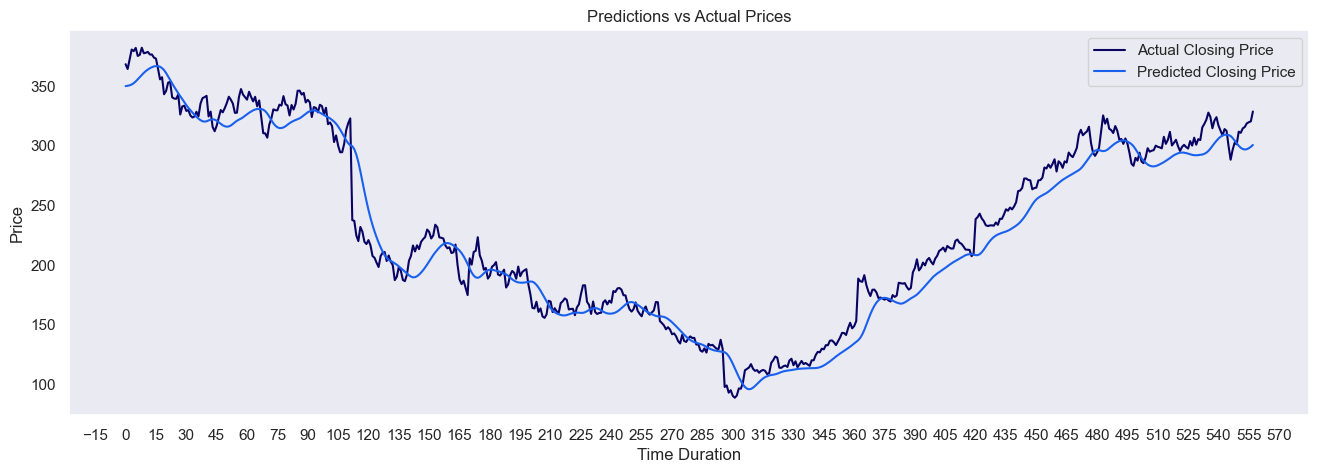

In [125]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)

# Using the LSTM model to make predictions on test data
test_data_scaled = x_test
actual_test_data = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
test_predictions_scaled = model_final_lstm.predict(test_data_scaled)
test_predictions = scaler_pred.inverse_transform(test_predictions_scaled.reshape(-1, 1))

# Plotting actual vs predicted closing prices
plt.plot(np.arange(len(actual_test_data)), actual_test_data, label="Actual Closing Price")
plt.plot(np.arange(len(test_predictions)), test_predictions, label="Predicted Closing Price")
plt.title("Predictions vs Actual Prices")
plt.ylabel("Price")
plt.xlabel("Time Duration")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
plt.legend(loc="upper right")
plt.grid()
plt.show
